In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx import circuit
from pyzx import *
from pyzx.parity_maps import CNOT_tracker, build_random_parity_map
from pyzx.linalg import Mat2
from pyzx.simplify import full_reduce

Load comb circuits

In [2]:
comb_circuit_folder = "../circuits/combs/"

circuit_properties = {"Qubits"    : 3,
                      "CNOTs"     : 2,
                      "Non-CNOTs" : 1}
path = os.path.join(comb_circuit_folder, 
                    str(circuit_properties["Qubits"])+"qubits", 
                    str(circuit_properties["CNOTs"])+"cnots", 
                    str(circuit_properties["Non-CNOTs"])+"non-cnots")
loaded_circuits = []
if os.path.exists(path):
    for file_name in os.listdir(path):
        loaded_circuits.append(circuit.Circuit.from_qasm_file(os.path.join(path, file_name)))
else:
    print("Directory Does Not Exist")

In [3]:
def extract_sub_matrix(matrix, index_list):
    new_matrix = Mat2(np.zeros([len(index_list), matrix.cols()], dtype=int))
    for row in range(new_matrix.rows()):
        for col in range(new_matrix.cols()):
            new_matrix.data[row][col] = matrix.data[index_list[row]][col]
    return new_matrix
def insert_sub_matrix(matrix, sub_matrix, index_list):
    for row in range(sub_matrix.rows()):
        for col in range(sub_matrix.cols()):
            matrix.data[index_list[row]][col] = sub_matrix.data[row][col]
    return matrix
def remove_rowcol(matrix, index):
    matrix.data = np.delete(matrix.data, index, 0)
    matrix.data = np.delete(matrix.data, index, 1)
    print(matrix)

In [4]:
def elimination_order(comb):
    #return list(range(comb.qubits))
    return [2,0,1,3]

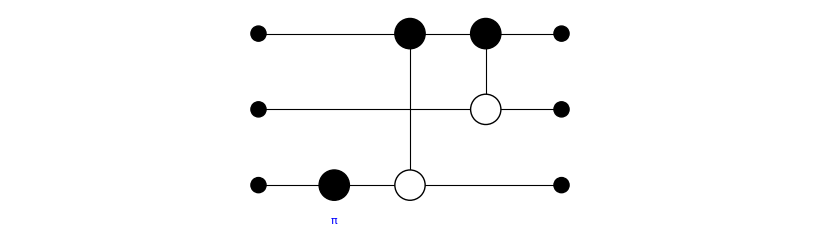

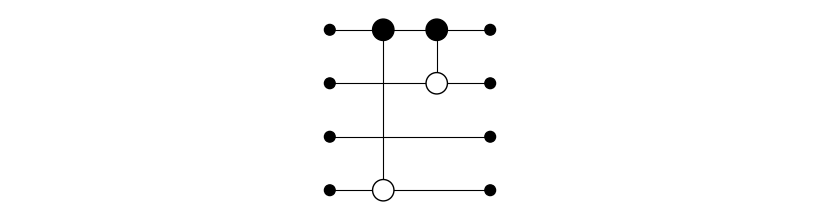

[ 1.0  1.0  0.0  1.0 ]
[ 0.0  1.0  0.0  0.0 ]
[ 0.0  0.0  1.0  0.0 ]
[ 0.0  0.0  0.0  1.0 ]
dict_keys([3])
{3: 2}
Qubit to eliminate 2 (2)
3q-fully_connected
ROWCOL -  2 [0, 1, 2]
[ 1  1  0  1 ]
[ 0  1  0  0 ]
[ 0  0  1  0 ]
Eliminate the column
[ 1  1  0  1 ]
[ 0  1  0  0 ]
[ 0  0  1  0 ]
Eliminate the row
[]


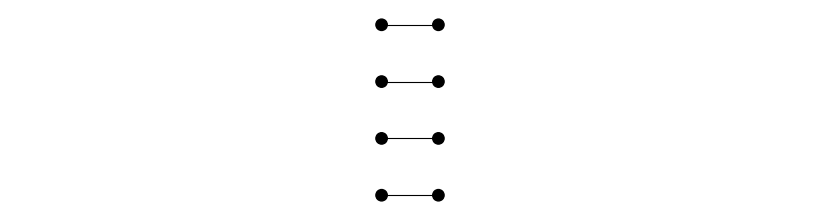

dict_keys([])
{3: 2}
Qubit to eliminate 0 (0)
3q-fully_connected
ROWCOL -  0 [0, 1, 2]
[ 1  1  0  1 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]
Eliminate the column
[ 1  1  0  1 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]
Eliminate the row
System solution - X [1. 1.]
Rows to add [0, 1, 2]
Pre-calculated outcome of adding those rows. [1, 0, 0]
[]


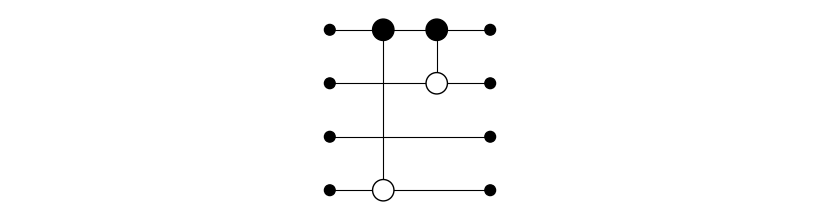

dict_keys([])
{3: 2}
Qubit to eliminate 1 (1)
3q-fully_connected
ROWCOL -  1 [1, 2]
[ 1  0  0  0 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]
Eliminate the column
[ 1  0  0  0 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]
Eliminate the row
[CNOT(3,0), CNOT(1,0)]


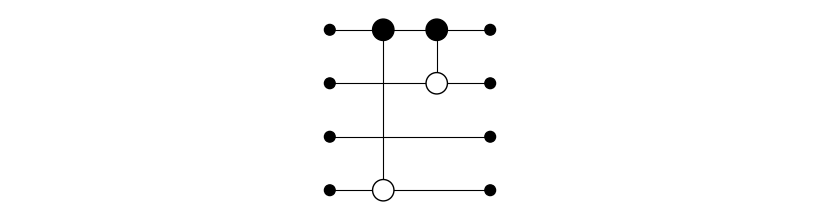

dict_keys([])
{3: 2}
Qubit to eliminate 3 (2)
3q-fully_connected
ROWCOL -  2 [2]
[ 1  0  0  0 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]
Eliminate the column
[ 1  0  0  0 ]
[ 0  1  0  0 ]
[ 0  0  0  1 ]
Eliminate the row
[CNOT(3,0), CNOT(1,0)]


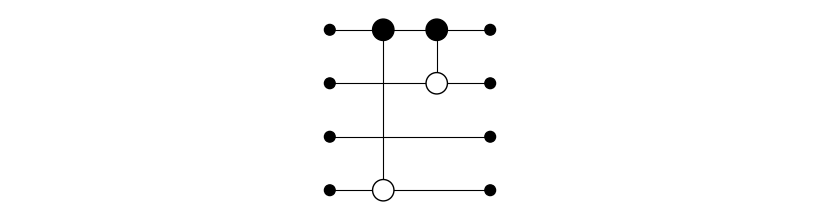

In [5]:
from IPython.display import display, Markdown

DEBUG = True

circ = loaded_circuits[1].copy()
display(zx.draw(circ))
comb = CombDecomposition.from_circuit(circ).comb
display(zx.draw(comb))
new_comb = CNOTComb(comb.qubits, comb.holes, comb.new_to_old_qubit_mappings)
arch = architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=circ.qubits)
# Create a copy of the parity matrix of the comb to perform gaussian elimination on
matrix = comb.matrix.copy()


DEBUG and print(comb.matrix)


# Find initial qubits for the sub matrix
qubits_in_matrix = []
for qubit in range(comb.qubits):
    if qubit not in comb.holes.values():
        qubits_in_matrix.append(qubit)

# These are the qubits still accessible on the architecture
# This doesn't include virtual qubits
accessible_qubits = list(range(circ.qubits)) 
rowcols_to_eliminate = elimination_order(comb)
rowcol_index = 0
while rowcol_index < len(rowcols_to_eliminate):
    # Generate sub matrix
    sub_matrix = extract_sub_matrix(matrix, qubits_in_matrix)
    sub_circuit = CNOT_tracker(circ.qubits)
    qubit_to_eliminate = rowcols_to_eliminate[rowcol_index]
    DEBUG and print(comb.holes.values())
    DEBUG and print(comb.new_to_old_qubit_mappings)

    if qubit_to_eliminate in comb.new_to_old_qubit_mappings:
        qubit_to_eliminate = comb.new_to_old_qubit_mappings[qubit_to_eliminate]
    
    DEBUG and print(f"Qubit to eliminate {rowcols_to_eliminate[rowcol_index]} ({qubit_to_eliminate})")
    
    # Remove current rowcol from matrix
    rowcol_iteration(sub_matrix, # need to generate correct sub matrix
                     arch,
                     qubit_to_eliminate, # rowcol needs to 'see' the virtual qubit as the original
                     accessible_qubits, # need to generate list of qubits currently accessible
                     circuit=sub_circuit)
    DEBUG and print(new_comb.gates)
    
    # Convert the gates of the sub matrix using the mapping
    for gate in sub_circuit.gates:
        gate.control = qubits_in_matrix[gate.control]
        gate.target = qubits_in_matrix[gate.target]
        # Add gates from sub circuit to comb circuit
        new_comb.gates.append(gate)
    # Insert submatrix back into larger matrix
    insert_sub_matrix(matrix, sub_matrix, qubits_in_matrix)    
    
    # If the qubit just removed maps to another qubit via a hole
    # replace that qubit with the new qubit in the qubits_in_matrix list
    for qubit_loc, qubit in enumerate(qubits_in_matrix):
        if qubit == rowcols_to_eliminate[rowcol_index]:
            if qubit in comb.holes.keys():
                qubits_in_matrix[qubit_loc] = comb.holes.pop(qubit)
            else:
                if qubit in comb.new_to_old_qubit_mappings:
                    accessible_qubits.remove(comb.new_to_old_qubit_mappings[qubit])
                else:
                    accessible_qubits.remove(qubit)

    # Update index
    rowcol_index += 1
    
    display(zx.draw(new_comb))

In [6]:
matrix = Mat2(np.array([[1,1,0,1],
                        [0,1,0,0],
                        [0,0,0,1]]))
choice = 0
rowcols_to_eliminate = [0,1,2]
A_inv = matrix.copy().data
A_inv = np.delete(A_inv, choice, 0)
A_inv = np.delete(A_inv, choice, 1)
A_inv = np.linalg.pinv(A_inv)
B = np.array(matrix.data[choice])
B = np.delete(B, choice, 0)
#Mat2([[matrix.data[row][col] for row in rowcols_to_eliminate if row != choice] for col  in rowcols_to_eliminate if col != choice])
print(A_inv)
print(B)
print(B.dot(A_inv))
#print(np.linalg.pinv(matrix.data))

[[1. 0.]
 [0. 0.]
 [0. 1.]]
[1 0 1]
[1. 1.]


In [7]:
np.dot(np.linalg.pinv(matrix.data), matrix.data)

array([[ 1.,  0.,  0.,  0.],
       [-0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-0., -0.,  0.,  1.]])